<a href="https://colab.research.google.com/github/jjeong-SH/Datacampus_team9/blob/main/0809_pytorch_koBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3.3.0

     |████████████████████████████████| 1.1 MB 4.8 MB/s 
     |████████████████████████████████| 895 kB 16.5 MB/s 
     |████████████████████████████████| 1.2 MB 22.9 MB/s 
     |████████████████████████████████| 3.0 MB 39.9 MB/s 


In [ ]:
!pip install mxnet

     |████████████████████████████████| 46.9 MB 77 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
!pip install gluonnlp pandas tqdm

     |████████████████████████████████| 344 kB 5.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595746 sha256=4dac26d23b260f79cb8334c8ed291e7891f37e9cff685c1c6e522f938935361d
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


In [ ]:
!pip install sentencepiece

In [ ]:
!pip install kss

     |████████████████████████████████| 65 kB 2.8 MB/s 


In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-asrcw83_
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-asrcw83_
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=12770 sha256=03c03c7939850f1903f17f461f536304cd4aa8ec2742ca391b5693a9abeda517
  Stored in directory: /tmp/pip-ephem-wheel-cache-5cpkqn74/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
##GPU 사용 시
device = torch.device("cuda:0")

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/데청캠_teamproject/정상희/0807_dataaug_onlytales.csv', encoding='utf-8-sig')

In [ ]:
df.sample(10)

,wav_id,contents,sentiment
22011,5e363f5a8661d6073410fe4b,으! 화장실에 누가 토하고 안 치웠어!,disgust
17601,5f07cb60b140144dfcff0b24,잠깐 쉬었으니 다 들어가서 일해야지 내일까지 마감해야 되거든.\t,sadness
20734,5ece4c2b2880d70f28611ff8,지금 당장 관리하시는 분한테 화장실 사건에 대해서 말씀 드려야겠어. 얼른 처리해달라...,disgust
6607,5f8da3c19e04b149046cd6a1,선수는 아니고 내가 운동을 좋아해서 시작했어.,happiness
9975,5fb8918c576e9378b67ac2d8,좋은 생각이다. 나쁘지 않을 것 같아. 고마워.,anger
2863,5f6705a5d338b948c4e6823e,다행히 빨리 잡아서 진정이 됐어.,surprise
13829,5fbdd1afcb503578af9eeb39,응. 완전 해방이야. 이제 친구들이랑 놀 거야.,happiness
20495,5f08018bb140144dfcff0f32,지금 바이러스가 한참 퍼져있는 강남이야.,fear
6391,5f8cd13e9e04b149046cd56a,비가 와도 걱정 안 해도 돼. 사무실에 우산 있어.,neutral
11029,5fb9fbb244697678c497b255,축하해줘. 기분 좋은 일이 생겼어.,happiness


In [ ]:
print('전체 data 개수: {}'.format(len(df)))

전체 data 개수: 26369


In [ ]:
sents = pd.Series(df['contents'].tolist()).astype(str)
sents_length = sents.apply(len)  # 띄어쓰기 포함

No handles with labels found to put in legend.


Text(0, 0.5, 'Probability')

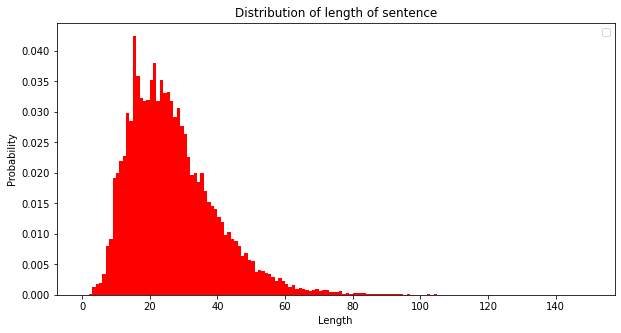

In [ ]:
# Visualize by graph
plt.figure(figsize=(10, 5))
plt.hist(sents_length, bins=150, range=[0,150], facecolor='r', density=True)
plt.title('Distribution of length of sentence', fontsize=12)
plt.legend()
plt.xlabel('Length', fontsize=10)
plt.ylabel('Probability', fontsize=10)

In [ ]:
print("문장 길이 최댓값 : ", np.max(sents_length))
print("문장 길이 최솟값 : ", np.min(sents_length))
print("문장 길이 평균값 : ", np.mean(sents_length))
print("문장 길이 표준편차 : ", np.std(sents_length))
print("문장 길이 제1사분위 : ", np.percentile(sents_length,25))
print("문장 길이 제3사분위 : ", np.percentile(sents_length, 75))
print("문장 길이 99퍼센트 : ", np.percentile(sents_length, 99))

문장 길이 최댓값 :  122
문장 길이 최솟값 :  2
문장 길이 평균값 :  26.236717357503128
문장 길이 표준편차 :  12.942338669588445
문장 길이 제1사분위 :  17.0
문장 길이 제3사분위 :  33.0
문장 길이 99퍼센트 :  67.0


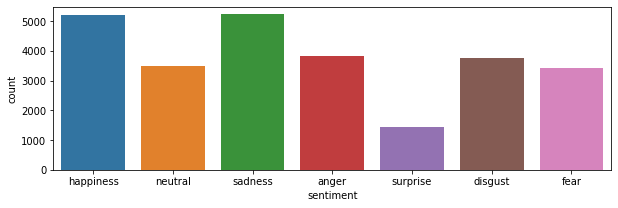

In [ ]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 3)
sns.countplot(data=df, x=df['sentiment'])

In [ ]:
def cleaning(sent):
  sent_clean = re.sub("[\t\n]", "", sent)
  sent_clean = re.sub("[^가-힣ㄱ-하-ㅣ!.,?\\d\\s]", "", sent_clean)
  sent_clean = re.sub("\s{2,}", " ", sent_clean)
  return sent_clean

label_dict = {'neutral':0, 'happiness':1, 'surprise':2, 'disgust':3, 'fear':4, 'anger':5, 'sadness':6}
def convert_int(label):
  num_label = label_dict[label]
  return num_label

df['sentiment_id'] = df['sentiment'].apply(convert_int)

In [ ]:
df.sample(5)

,wav_id,contents,sentiment,sentiment_id
19218,5eccb0e4c90a530ee56b5596,매일 드시는 것 같아. 매주 5일은 드시지.,anger,5
10290,5fbb816f4c55eb78bd7ce67f,생각해보니 내가 잘못한거 같아.,neutral,0
13072,5fbb6839576e9378b67acb59,당연하지. 사진 찍었어.,disgust,3
4971,5f6ddfd4111dfd48d40fd1f0,난 영화 보는 걸로 선택할게. 영화 좀 추천해줘.,anger,5
11103,5fb9c8214c55eb78bd7cdfd6,주식으로 너무 많이 잃어서 인생 좆됐어 진짜.,sadness,6


In [ ]:
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(df, test_size=0.1, stratify=df['sentiment_id'], random_state=123)
# 레이블 수가 고르지 않아서 validation set 만들때 stratified를 못쓴다...
print('PROPORTION OF TARGET IN THE ORIGINAL DATA')
print(df['sentiment_id'].value_counts() / len(df))
print('\n')
print('PROPORTION OF TARGET IN THE TRAINING SET')
print(train_data['sentiment_id'].value_counts() / len(train_data))
print('\n')
print('PROPORTION OF TARGET IN THE TEST SET')
print(test_data['sentiment_id'].value_counts() / len(test_data))

PROPORTION OF TARGET IN THE ORIGINAL DATA
6    0.198036
1    0.197998
5    0.145246
3    0.142326
0    0.131859
4    0.129546
2    0.054989
Name: sentiment_id, dtype: float64


PROPORTION OF TARGET IN THE TRAINING SET
6    0.198045
1    0.198003
5    0.145247
3    0.142339
0    0.131847
4    0.129530
2    0.054989
Name: sentiment_id, dtype: float64


PROPORTION OF TARGET IN THE TEST SET
1    0.197952
6    0.197952
5    0.145241
3    0.142207
0    0.131968
4    0.129693
2    0.054987
Name: sentiment_id, dtype: float64


In [ ]:
print("train data 크기: {}".format(train_data.shape))
print("test data 크기: {}".format(test_data.shape))

train data 크기: (23732, 4)
test data 크기: (2637, 4)


In [ ]:
def to_datasets(df):
  set_list = []
  for sent, label in tqdm(zip(df['contents'], df['sentiment_id']), total=len(df)):
    try:
        data = []
        data.append(cleaning(sent))
        data.append(str(label))
        set_list.append(data)

    except Exception as e:
        print(e)
        print(sent)
        pass
        
  return set_list

In [ ]:
dataset_train = to_datasets(train_data)
dataset_test = to_datasets(test_data)

100%|██████████| 2637/2637 [00:00<00:00, 191927.18it/s]


In [ ]:
# print examples
print(dataset_train[0])
print(dataset_train[6000])
print(dataset_train[12000])
print(dataset_train[18000])

['이따가 친구 만나서 병원에 같이 가보기로 했어.', '4']
['바쁘게 진행하는 일이 끝나면 가려고 했는데 요즘 정말 바빠 시간을 낼 수가 없어.', '6']
['헐! 나 이벤트 당첨됐어.', '1']
['곰팡이 제거제가 곰팡이를 제거하는데 효과가 있대?', '5']


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
## Setting parameters
max_len = int(np.percentile(sents_length, 85))
batch_size = 32
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate = 3e-5
patience = 3

In [ ]:
# tokenize
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
data_train[0]

(array([   2, 3647, 5959, 5330, 4627, 1933, 6553, 2353, 6896,  834,  517,
        5330, 6368, 6079, 5017, 6855,  517,   54,    3,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1], dtype=int32),
 array(19, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 4)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# epoch당 average training loss를 track
avg_train_losses = []
# epoch당 average validation loss를 track
avg_valid_losses = []

# epoch당 average train acc를 track
train_acc = []
# epoch당 average validation acc를 track
valid_acc = []
# epoch당 average train acc를 track
avg_train_acc = []
# epoch당 average validation acc를 track
avg_valid_acc = []

# early_stopping object의 초기화
early_stopping = EarlyStopping(patience = patience, verbose = True)

for e in range(num_epochs):
    train_accs = 0.0
    valid_accs = 0.0
    
    ###################
    # train the model #
    ###################
    print("\t>>> epoch {} training start <<<".format(e+1))
    model.train() # prep model for training
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_accs += calc_accuracy(out, label)
        train_acc.append(calc_accuracy(out, label))
        train_losses.append(loss.item())
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_accs / (batch_id+1)))
    print("epoch {} train loss {} acc {}".format(e+1, loss.data.cpu().numpy(), train_accs / (batch_id+1)))

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        valid_accs += calc_accuracy(out, label)
        valid_acc.append(calc_accuracy(out, label))
        valid_losses.append(loss.item())
    print("epoch {} validation loss {} acc {}".format(e+1, loss.data.cpu().numpy(), valid_accs / (batch_id+1)))
    
    # print 학습/검증 statistics
    # epoch당 평균 loss 계산
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    # print 학습/검증 statistics
    # epoch당 평균 loss 계산
    train_accuracy = np.average(train_acc)
    valid_accuracy = np.average(valid_acc)
    avg_train_acc.append(train_accuracy)
    avg_valid_acc.append(valid_accuracy)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []
            
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
            
    if early_stopping.early_stop:
        print("---------Quit training due to Early stopping---------")
        break
    print("\n\n")

  0%|          | 0/742 [00:00<?, ?it/s]

	>>> epoch 1 training start <<<


  0%|          | 2/742 [00:00<03:55,  3.14it/s]

epoch 1 batch id 1 loss 1.9448251724243164 acc 0.15625


 27%|██▋       | 202/742 [00:30<01:20,  6.72it/s]

epoch 1 batch id 201 loss 1.8236241340637207 acc 0.16868781094527363


 54%|█████▍    | 402/742 [00:59<00:50,  6.77it/s]

epoch 1 batch id 401 loss 1.3695435523986816 acc 0.2649625935162095


 81%|████████  | 602/742 [01:29<00:20,  6.72it/s]

epoch 1 batch id 601 loss 0.9776369333267212 acc 0.38924708818635606


  0%|          | 0/83 [00:00<?, ?it/s]

epoch 1 train loss 0.520962655544281 acc 0.45599730458221027


100%|██████████| 83/83 [00:03<00:00, 21.36it/s]


epoch 1 validation loss 0.5656033754348755 acc 0.7978452270620945
Validation loss decreased (inf --> 0.661022).  Saving model ...


  0%|          | 0/742 [00:00<?, ?it/s]




	>>> epoch 2 training start <<<


  0%|          | 2/742 [00:00<02:48,  4.39it/s]

epoch 2 batch id 1 loss 0.5867730975151062 acc 0.84375


 27%|██▋       | 202/742 [00:29<01:19,  6.77it/s]

epoch 2 batch id 201 loss 0.5490589141845703 acc 0.8006840796019901


 54%|█████▍    | 402/742 [00:59<00:50,  6.76it/s]

epoch 2 batch id 401 loss 0.3820697069168091 acc 0.8170199501246883


 81%|████████  | 602/742 [01:29<00:20,  6.75it/s]

epoch 2 batch id 601 loss 0.6198052167892456 acc 0.8283069883527454


  0%|          | 0/83 [00:00<?, ?it/s]

epoch 2 train loss 0.19779999554157257 acc 0.8327324797843666


100%|██████████| 83/83 [00:03<00:00, 21.20it/s]


epoch 2 validation loss 0.09545482695102692 acc 0.8618222891566265
Validation loss decreased (0.661022 --> 0.437540).  Saving model ...


  0%|          | 0/742 [00:00<?, ?it/s]




	>>> epoch 3 training start <<<


  0%|          | 2/742 [00:00<02:56,  4.19it/s]

epoch 3 batch id 1 loss 0.23499391973018646 acc 0.9375


 27%|██▋       | 202/742 [00:30<01:20,  6.74it/s]

epoch 3 batch id 201 loss 0.47438013553619385 acc 0.877021144278607


 54%|█████▍    | 402/742 [00:59<00:50,  6.76it/s]

epoch 3 batch id 401 loss 0.2007647156715393 acc 0.8830268079800498


 81%|████████  | 602/742 [01:29<00:20,  6.74it/s]

epoch 3 batch id 601 loss 0.36772528290748596 acc 0.8875831946755408


  0%|          | 0/83 [00:00<?, ?it/s]

epoch 3 train loss 0.17997264862060547 acc 0.8903470350404313


100%|██████████| 83/83 [00:03<00:00, 21.29it/s]


epoch 3 validation loss 0.07498414814472198 acc 0.8862951807228916
Validation loss decreased (0.437540 --> 0.372198).  Saving model ...


  0%|          | 0/742 [00:00<?, ?it/s]




	>>> epoch 4 training start <<<


  0%|          | 2/742 [00:00<02:51,  4.31it/s]

epoch 4 batch id 1 loss 0.06026693060994148 acc 1.0


 27%|██▋       | 202/742 [00:29<01:19,  6.77it/s]

epoch 4 batch id 201 loss 0.2938831150531769 acc 0.9148009950248757


 54%|█████▍    | 402/742 [00:59<00:50,  6.75it/s]

epoch 4 batch id 401 loss 0.10850877314805984 acc 0.9191864089775561


 81%|████████  | 602/742 [01:29<00:20,  6.77it/s]

epoch 4 batch id 601 loss 0.2048950344324112 acc 0.9216410149750416


  0%|          | 0/83 [00:00<?, ?it/s]

epoch 4 train loss 0.13572381436824799 acc 0.9225657008086254


  0%|          | 0/742 [00:00<?, ?it/s]

epoch 4 validation loss 0.030925389379262924 acc 0.8942018072289156
EarlyStopping counter: 1 out of 3



	>>> epoch 5 training start <<<


  0%|          | 2/742 [00:00<02:48,  4.39it/s]

epoch 5 batch id 1 loss 0.1341562122106552 acc 0.96875


 27%|██▋       | 202/742 [00:30<01:19,  6.76it/s]

epoch 5 batch id 201 loss 0.259511798620224 acc 0.9305037313432836


 54%|█████▍    | 402/742 [00:59<00:50,  6.73it/s]

epoch 5 batch id 401 loss 0.060015253722667694 acc 0.9358634663341646


 81%|████████  | 602/742 [01:29<00:20,  6.76it/s]

epoch 5 batch id 601 loss 0.29135435819625854 acc 0.9366160565723793


  0%|          | 0/83 [00:00<?, ?it/s]

epoch 5 train loss 0.17190903425216675 acc 0.9384012803234502


  0%|          | 0/742 [00:00<?, ?it/s]

epoch 5 validation loss 0.06771479547023773 acc 0.8906394810009267
EarlyStopping counter: 2 out of 3



	>>> epoch 6 training start <<<


  0%|          | 2/742 [00:00<02:48,  4.39it/s]

epoch 6 batch id 1 loss 0.008828114718198776 acc 1.0


 27%|██▋       | 202/742 [00:30<01:20,  6.74it/s]

epoch 6 batch id 201 loss 0.2913617789745331 acc 0.9496268656716418


 54%|█████▍    | 402/742 [00:59<00:50,  6.73it/s]

epoch 6 batch id 401 loss 0.0700962021946907 acc 0.9519170822942643


 81%|████████  | 602/742 [01:29<00:20,  6.77it/s]

epoch 6 batch id 601 loss 0.4016283452510834 acc 0.9530990016638935


  0%|          | 0/83 [00:00<?, ?it/s]

epoch 6 train loss 0.06827498972415924 acc 0.9529733827493262


100%|██████████| 83/83 [00:03<00:00, 21.22it/s]

epoch 6 validation loss 0.016231806948781013 acc 0.8998493975903614
EarlyStopping counter: 3 out of 3
---------Quit training due to Early stopping---------


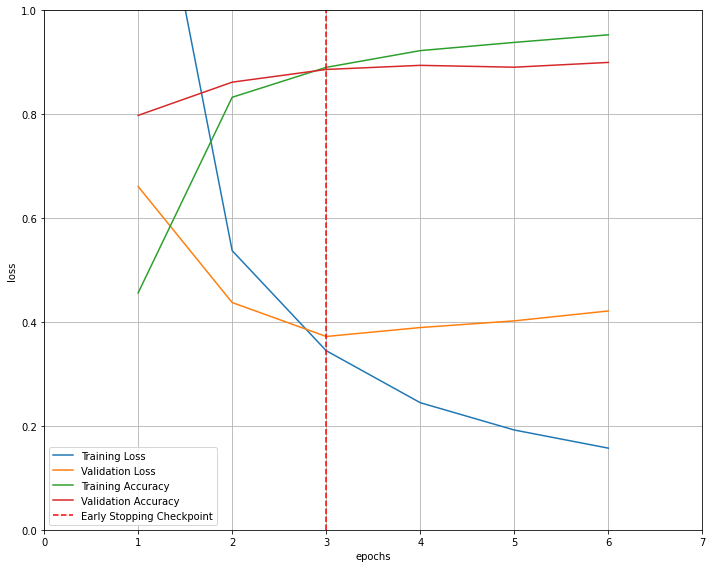

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')
plt.plot(range(1,len(avg_train_acc)+1),avg_train_acc,label='Training Accuracy')
plt.plot(range(1,len(avg_valid_acc)+1),avg_valid_acc,label='Validation Accuracy')

# validation loss의 최저값 지점을 찾기
minposs = avg_valid_losses.index(min(avg_valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # 일정한 scale
plt.xlim(0, len(avg_train_losses)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
with open("/content/drive/MyDrive/데청캠_teamproject/정상희/빨간모자.txt", "r") as f:
    data = f.read()

In [ ]:
data

'옛날 옛날에 모두의 사랑을 받는 작고 귀여운 소녀가 있었습니다. 하지만 그 소녀를 가장 사랑하는 것은 그녀의 할머니였습니다. 할머니는 소녀에게 무엇을 줘야 할지 몰랐습니다. 한번은 할머니가 소녀에게 붉은 벨벳으로 만들어진 모자를 선물했습니다. 소녀에게 그 모자가 잘 어울렸고, 소녀가 그 모자가 아닌 다른 것은 쓰지 않으려고 했습니다. 그래서 그 소녀는 \'빨간 모자\'라고 불렸습니다. 어느 날, 소녀의 엄마가 그녀에게 말했습니다. "빨간 모자, 여기로 와보렴. 여기 케이크 한 조각과 와인 한 병을 할머니에게 가져다 주렴. 할머니가 편찮으시니까 네가 가면 기뻐하실 거야. 더워지기 전에 출발하렴. 그리고 할머니 댁에 갈 때, 조심해서 가고 길에서 벗어나지 마렴. 그렇지 않으면 네가 넘어져서 병을 깨뜨릴 거야. 그러면 할머니는 아무것도 받지 못하신단다. 그리고 할머니 방에 가면, 먼저 인사하고 방 안 구석구석을 살펴보는 것을 잊지 말아라!"\n\n"엄마 말 잘 들을게요." 빨간 머리가 엄마에게 말했습니다. 하지만 할머니는 마을에서 30분 떨어진 거리에 있는 숲에 사셨습니다. 빨간 모자가 숲에 같을 때, 그녀는 늑대를 만났습니다. 하지만 빨간 모자는 늑대가 얼마나 나쁜 동물인지 몰랐고 늑대를 무서워하지 않았습니다. "안녕, 빨간 모자!" 늑대가 말했습니다. "고마워, 늑대!" – " 빨간 모자야, 이렇게 일찍 어딜 가니?" – "할머니께" – "무엇을 가져가니?" – "케이크와 와인. 어제 우리가 편찮으신 할머니께 좋은 것을 드리고 기운 내게 해드리려고 케이크를 만들었어." – "빨간 모자야, 너희 할머니는 어디 사시니?" – "여기서도 15분 더 숲 속으로 가야 해. 3개의 오크 나무 아래에 할머니 집이 있어. 그 아래에는 개암나무가 있어. 너도 거기를 알거야." 빨간 모자가 말했습니다. 늑대는 혼자 생각했습니다. \'저 어리고 상냥한 한입거리가 노인보다 훨씬 맛있을거야. 둘 다 잡아먹으려면 빨리 꾀를 생각해내야 해.\' 늑대가 빨간 모자 옆으로 가서 말했습니다.

In [ ]:
data = cleaning(data)
data

'옛날 옛날에 모두의 사랑을 받는 작고 귀여운 소녀가 있었습니다. 하지만 그 소녀를 가장 사랑하는 것은 그녀의 할머니였습니다. 할머니는 소녀에게 무엇을 줘야 할지 몰랐습니다. 한번은 할머니가 소녀에게 붉은 벨벳으로 만들어진 모자를 선물했습니다. 소녀에게 그 모자가 잘 어울렸고, 소녀가 그 모자가 아닌 다른 것은 쓰지 않으려고 했습니다. 그래서 그 소녀는 빨간 모자라고 불렸습니다. 어느 날, 소녀의 엄마가 그녀에게 말했습니다. 빨간 모자, 여기로 와보렴. 여기 케이크 한 조각과 와인 한 병을 할머니에게 가져다 주렴. 할머니가 편찮으시니까 네가 가면 기뻐하실 거야. 더워지기 전에 출발하렴. 그리고 할머니 댁에 갈 때, 조심해서 가고 길에서 벗어나지 마렴. 그렇지 않으면 네가 넘어져서 병을 깨뜨릴 거야. 그러면 할머니는 아무것도 받지 못하신단다. 그리고 할머니 방에 가면, 먼저 인사하고 방 안 구석구석을 살펴보는 것을 잊지 말아라!엄마 말 잘 들을게요. 빨간 머리가 엄마에게 말했습니다. 하지만 할머니는 마을에서 30분 떨어진 거리에 있는 숲에 사셨습니다. 빨간 모자가 숲에 같을 때, 그녀는 늑대를 만났습니다. 하지만 빨간 모자는 늑대가 얼마나 나쁜 동물인지 몰랐고 늑대를 무서워하지 않았습니다. 안녕, 빨간 모자! 늑대가 말했습니다. 고마워, 늑대! 빨간 모자야, 이렇게 일찍 어딜 가니? 할머니께 무엇을 가져가니? 케이크와 와인. 어제 우리가 편찮으신 할머니께 좋은 것을 드리고 기운 내게 해드리려고 케이크를 만들었어. 빨간 모자야, 너희 할머니는 어디 사시니? 여기서도 15분 더 숲 속으로 가야 해. 3개의 오크 나무 아래에 할머니 집이 있어. 그 아래에는 개암나무가 있어. 너도 거기를 알거야. 빨간 모자가 말했습니다. 늑대는 혼자 생각했습니다. 저 어리고 상냥한 한입거리가 노인보다 훨씬 맛있을거야. 둘 다 잡아먹으려면 빨리 꾀를 생각해내야 해. 늑대가 빨간 모자 옆으로 가서 말했습니다. 빨간 모자야, 여기 주변에 있는 예쁜 꽃들 좀 봐. 왜 주변을 둘러보지 않니? 

In [ ]:
import kss

new_datalines = kss.split_sentences(data)
len(new_datalines)

112

In [ ]:
pred = pd.DataFrame({"contents": new_datalines})

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [ ]:
def predict(predict_sentence):
    sentiment_list = []

    for sentence in predict_sentence:
        data = [sentence, '0']
        dataset_another = [data]

        another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
        test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=4)
        
        model.eval()
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            test_eval=[]

            for i in out:
                logits=i
                logits = logits.detach().cpu().numpy()
                if np.argmax(logits) == 0:
                    test_eval.append('neutral')
                elif np.argmax(logits) == 1:
                    test_eval.append('happiness')
                elif np.argmax(logits) == 2:
                    test_eval.append('surprise')
                elif np.argmax(logits) == 3:
                    test_eval.append('disgust')
                elif np.argmax(logits) == 4:
                    test_eval.append('fear')
                elif np.argmax(logits) == 5:
                    test_eval.append('anger')
                elif np.argmax(logits) == 6:
                    test_eval.append('sadness')

            sentiment_list.append(test_eval[0])

    return sentiment_list

In [ ]:
sents = list(pred['contents'])
sentiment_list = predict(sents)

In [ ]:
pred['sentiment'] = sentiment_list
pred.head()

,contents,sentiment
0,옛날 옛날에 모두의 사랑을 받는 작고 귀여운 소녀가 있었습니다.,neutral
1,하지만 그 소녀를 가장 사랑하는 것은 그녀의 할머니였습니다.,happiness
2,할머니는 소녀에게 무엇을 줘야 할지 몰랐습니다. 한번은 할머니가 소녀에게 붉은 벨벳...,happiness
3,"소녀에게 그 모자가 잘 어울렸고, 소녀가 그 모자가 아닌 다른 것은 쓰지 않으려고 ...",neutral
4,그래서 그 소녀는 빨간 모자라고 불렸습니다.,neutral


In [ ]:
pred.to_csv('/content/drive/MyDrive/데청캠_teamproject/정상희/0810_빨간모자_감정태깅_onlytales.csv', encoding='utf-8-sig', index=True)